In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mytools import Video
from sklearn.metrics import *

2023-12-10 02:34:33.574840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load model

The string value `load_parameter` define the method to choose.

If `load_parameter == 'new'` then the model with the last filename from the directory __models__ will be load. _I use the date and time to construct model filename._

Else the model with the heighest value in `load_parameter`-column from __metrics.csv__ will be load. That table contains columns:
- `'model path'`
- `'Total Accuracy'`
- `'Total Precision'`
- `'Total Recall',`
- `'Train Accuracy'`
- `'Train Precision'`
- `'Train Recall'`
- `'Test Accuracy'`
- `'Test Precision'`
- `'Test Recall'`

In [2]:
load_parameter = 'Total Precision'

if load_parameter == 'new':
    model_path = 'models'
    model_files = np.array(os.listdir(model_path))
    model_files = np.sort(model_files[np.char.find(model_files, '.h5') != -1])
    model_path = os.path.join(model_path, model_files[-1])
else:
    df_metrics = pd.read_csv('metrics.csv')
    model_path = df_metrics[df_metrics[load_parameter] == df_metrics[load_parameter].max()]['model path'].values[0]
    
print(f'We a going to upload model {model_path}')

We a going to upload model models/2023-12-09-01-39.h5


In [3]:
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 4, 70, 126, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 35, 63, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 32, 60, 64)     262208    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 16, 30, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 192)               5

In [4]:
input_size = tuple(model.input.shape[1:])
video_size = input_size[1], input_size[2]
print(f'Model input shape is {input_size}')
print(f'So video size should be {video_size}')

Model input shape is (6, 72, 128, 3)
So video size should be (72, 128)


## Define model predicts path

In [5]:
path_predicts = 'predicts'
if not os.path.exists(path_predicts):
    os.mkdir(path_predicts)

In [6]:
model_name = model_path[model_path.find('/')+1:model_path.find('.')]
path_model_predicts = os.path.join(path_predicts, model_name)

if not os.path.exists(path_model_predicts):
    os.mkdir(path_model_predicts)

In [7]:
path_predict_template = os.path.join(path_model_predicts, '{0}.npy')
path_predict_template

'predicts/2023-12-09-01-39/{0}.npy'

# Predictor

In [8]:
def predict_cuts(model, video: Video, fill=True, fill_value=0, fill_begin=None, fill_end=None):
    """
    Returns predicted cuts.
    
    Parameters:
    -----------
    model : keras model
    
    video : mytools.Video
    
    fill : bool
        Add values to the begin and end of result
    
    fill_value : int or bool
        Value, which will added to the begin and the end, if fill is True
        
    fill_begin : int
        Number of added values to begin
        
    fill_end : int
        Number of added values to end
    
    Returns:
    --------
    res : np.array
    """
    input_size = tuple(model.input.shape[1:])
    video_size = input_size[2], input_size[1]
    fragment_length = input_size[0]
    if (fill_begin is None) and (fill_end is None):
        fill_begin = fragment_length // 2
        fill_end = fragment_length - fill_begin
    elif fill_end is None:
        fill_end = fragment_length - fill_begin
    elif fill_begin is None:
        fill_begin = fragment_length - fill_end
    
    res = []
    
    pbar = tqdm(total=len(video) - fragment_length)
    # Make here loop of video fragments length 4 (fragment_length) and add predicted value every step
    for matrix in video.generate_matrices(matrix_length=fragment_length, new_size=video_size):
        X = matrix.reshape(np.append(1, matrix.shape))
        y = model(X)
        res.append(y)
        pbar.update()
    pbar.close()
    
    if fill:
        res = np.concatenate([np.ones(fill_begin)*fill_value, np.array(res)[:, 0, 0], np.ones(fill_end)*fill_value])
    return res

# Define Split Values 

In [9]:
path_trainset = os.path.join('trainsets', model_path[model_path.rfind('/')+1:model_path.rfind('.')] + '.npy')
sets = {'Total': np.arange(11), 
        'Train' : np.load(path_trainset)}
sets.update({'Test': np.setdiff1d(sets['Total'], sets['Train'])})

dfs_square_set = {}
sets

{'Total': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Train': array([0, 1, 4, 5, 7, 9]),
 'Test': array([ 2,  3,  6,  8, 10])}

# Make Predicts, Load Answers and Make Result DataFrame

In [10]:
predicts = []
for video_index in tqdm(sets['Total'], total=len(sets['Total'])):
    path_predict = path_predict_template.format(video_index)
    try:
        cuts_predicted = np.load(path_predict)
    except FileNotFoundError:
        cuts_predicted = predict_cuts(model, video)
        np.save(path_predict, cuts_predicted)
    predicts.append(np.array(cuts_predicted))

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
answers = []
for video_index in sets['Total']:
    video = Video(f'videos/{video_index}.mp4')
    cuts = np.load(f'cuts/{video_index}.npy').astype(int)
    cuts_real = np.zeros(len(video))
    cuts_real[cuts] = 1
    answers.append(cuts_real)

In [12]:
assert len(predicts) == len(answers)
assert (np.array([len(i) for i in predicts]) == np.array([len(i) for i in answers])).all()

In [13]:
df_answer_predict = []
for i in range(len(sets['Total'])):
    video_index = sets['Total'][i]
    dfi = pd.DataFrame({'Answer' : answers[i], 
                        'Predict' : predicts[i]})
    dfi['VideoId'] = video_index
    df_answer_predict.append(dfi.copy())
df_answer_predict = pd.concat(df_answer_predict, ignore_index=True)

print(f'df_predict_answer.shape = {df_answer_predict.shape}')
df_answer_predict.head()

df_predict_answer.shape = (62496, 3)


,Answer,Predict,VideoId
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0


# Plot Precision and Recall vs Parameter

__Reminder:__

$$
    Accuracy = \cfrac{TP + TN}{TP + TN + FP + FN}
$$

$$
    Precision = \cfrac{TP}{TP + FP}
$$

$$
    Recall = \cfrac{TP}{TP + FN}
$$

In [14]:
parameters = np.arange(0, 1.05, 0.04)

/home/fedora/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fedora/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fedora/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_52948/3392748985.py:17: UserWarning: Matplotlib is currently using module://matplotli

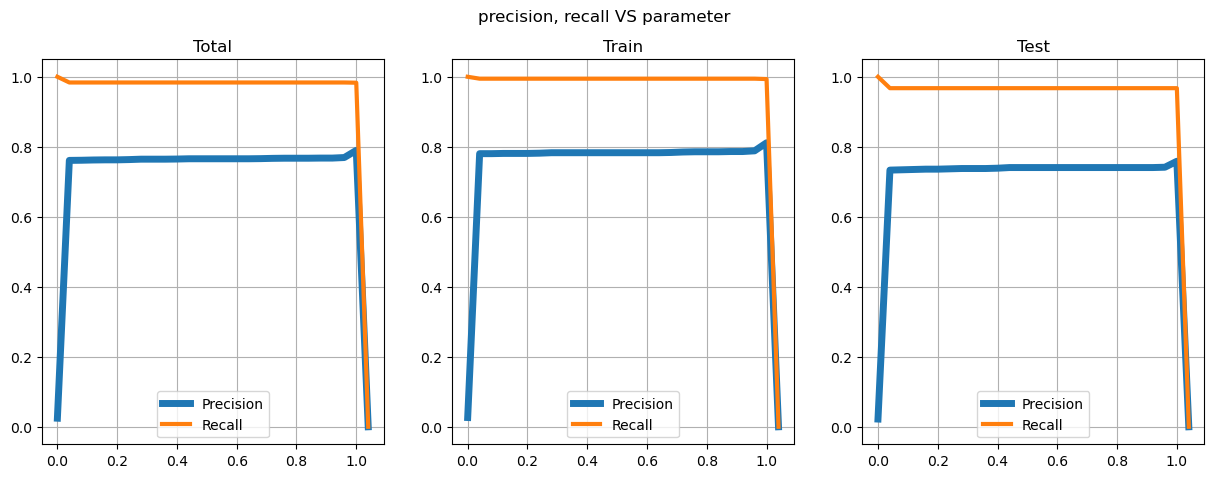

In [15]:
fig, axs = plt.subplots(1, len(sets))
fig.suptitle('precision, recall VS parameter')
fig.set_figheight(5)
fig.set_figwidth(5*len(sets))

for i in range(len(sets)):
    key = list(sets.keys())[i]
    axs[i].set_title(key)
    df_ap = df_answer_predict[np.isin(df_answer_predict['VideoId'], sets[key])]
    precisions = [precision_score(df_ap['Answer'], df_ap['Predict'] >= parameter) for parameter in parameters]
    recalls = [recall_score(df_ap['Answer'], df_ap['Predict'] >= parameter) for parameter in parameters]
    
    axs[i].plot(parameters, precisions, label='Precision', linewidth=5)
    axs[i].plot(parameters, recalls, label='Recall', linewidth=3)
    axs[i].grid(True)
    axs[i].legend()
fig.show()

Here we see, that precision and recall does not really depend from parameter.

Let's see the ROC-curve

# ROC-curve

/tmp/ipykernel_52948/4263494313.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


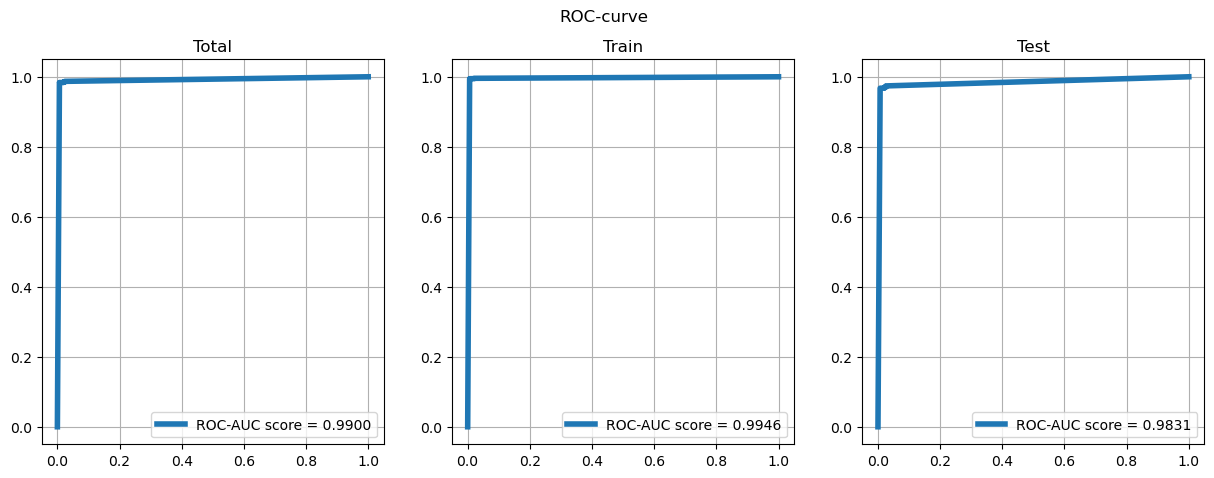

In [16]:
fig, axs = plt.subplots(1, len(sets))
fig.suptitle('ROC-curve')
fig.set_figheight(5)
fig.set_figwidth(5*len(sets))

for i in range(len(sets)):
    key = list(sets.keys())[i]
    axs[i].set_title(key)
    df_ap = df_answer_predict[np.isin(df_answer_predict['VideoId'], sets[key])]
    fpr, tpr, thresholds = roc_curve(df_ap['Answer'], df_ap['Predict'], pos_label=1)
    axs[i].plot(fpr, tpr, linewidth=4, 
                label = 'ROC-AUC score = {0:.4f}'.format(roc_auc_score(df_ap['Answer'], df_ap['Predict'])))
    axs[i].grid(True)
    axs[i].legend()
fig.show()

Surprisingly I got a ROC curve with the great predictive power!

# Conclusion

In [17]:
scores = [accuracy_score, precision_score, recall_score, roc_auc_score]

In [23]:
cutoff = 0.5
print(f'cutoff parameter is {cutoff}')

values = np.zeros([len(sets), len(scores)])
for i in range(len(sets)):
    key = list(sets.keys())[i]
    df_ap = df_answer_predict[np.isin(df_answer_predict['VideoId'], sets[key])]
    for k in range(len(scores)):
        score = scores[k]
        if score is roc_auc_score:
            values[i, k] = score(df_ap['Answer'], df_ap['Predict'])
        else:
            values[i, k] = score(df_ap['Answer'], df_ap['Predict'] >= cutoff)
        
df_scores0 = pd.DataFrame(values, columns=[score.__name__ for score in scores], index=[key for key in sets])
df_scores0

cutoff parameter is 0.5


,accuracy_score,precision_score,recall_score,roc_auc_score
Total,0.992224,0.765752,0.983681,0.989996
Train,0.992564,0.783019,0.994553,0.994622
Test,0.991798,0.740648,0.967427,0.983102


In [24]:
cutoff = 1
print(f'cutoff parameter is {cutoff}')

values = np.zeros([len(sets), len(scores)])
for i in range(len(sets)):
    key = list(sets.keys())[i]
    df_ap = df_answer_predict[np.isin(df_answer_predict['VideoId'], sets[key])]
    for k in range(len(scores)):
        score = scores[k]
        if score is roc_auc_score:
            values[i, k] = score(df_ap['Answer'], df_ap['Predict'])
        else:
            values[i, k] = score(df_ap['Answer'], df_ap['Predict'] >= cutoff)
        
df_scores1 = pd.DataFrame(values, columns=[score.__name__ for score in scores], index=[key for key in sets])
df_scores1

cutoff parameter is 1


,accuracy_score,precision_score,recall_score,roc_auc_score
Total,0.993168,0.789722,0.983029,0.989996
Train,0.993717,0.811388,0.993464,0.994622
Test,0.992482,0.758621,0.967427,0.983102


In [25]:
print('Increase:')
df_scores1 - df_scores0

Increase:


,accuracy_score,precision_score,recall_score,roc_auc_score
Total,0.000944,0.023970,-0.000653,0.0
Train,0.001153,0.028369,-0.001089,0.0
Test,0.000683,0.017972,0.000000,0.0


If increase cutoff parameter from 0.5 to 1, then accuracy and precision score will grow on test set, and recall score will decrease on test set but will not change on the test set.